# Intro Application to Machine Learning for Manufacturing

In this notebook, we will be applying Machine Learning to a synthetic dataset representing an automated process. Our goal for this portion of the session is to build a binary classification model to differentiate between good and bad processes. The process includes:

 1. Start point
 2. First increasing ramp
 3. 1<sup>st</sup> Hold
 4. Second increasing ramp
 5. 2<sup>nd</sup> Hold
 6. Decreasing ramp
 7. Stop

From our knowledge of the process machinery, we know that there is variation in the start and stop time of each step and in the signals value throughout each step.

> <u>Initial Leading Question</u>: Is a ML model able to differentiate between a **good** process and a **bad** process using the data that is already available?

---

## Overview
 - [ ] Importing data
 - [ ] Vizualizing the raw data
 - [ ] Setting up the model
 - [ ] Training the model
 - [ ] Understanding model performance
 - [ ] Tuning the model
 - [ ] Next steps: Training multiple models

## Importing libraries and data

In [1]:
# Import libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from math import sqrt

In [2]:
# Use the below lines to improve the resolution of the output plots
# This is not needed, but helpful if plots appear blurry or you are using a high DPI screen
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'

In [3]:
# Set to True for full outputs including plots and DataFrames. 
# Possibly LONG computation time for large datasets
debug = True

For Machine Learning, we use a dataset that contains the information that will be used by the model to learn 

In [4]:
# Set the directory where the data is stored
data_dir = 'data/'

# Training data filename
fname_train = 'train.csv'

# Testing data filename
fname_test = 'test.csv'

In [5]:
# Load the training and testing data
train_df = pd.read_csv(data_dir + fname_train) # Training data
test_df =  pd.read_csv(data_dir + fname_test) # Testing data

### Missing Values
Commonly, real-world data may have missing values or NaNs. Most ML models cannot be used on data that contains NaNs. One technique to correct for this is to fill any missing values with with zeros or the median value. Here we will fill the missing values with zeros as the missing data tends to be on the head and tail of the process data output for each run. This is common if the runs vary in duration. 

In [6]:
# Fill in any missing values with zeros
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

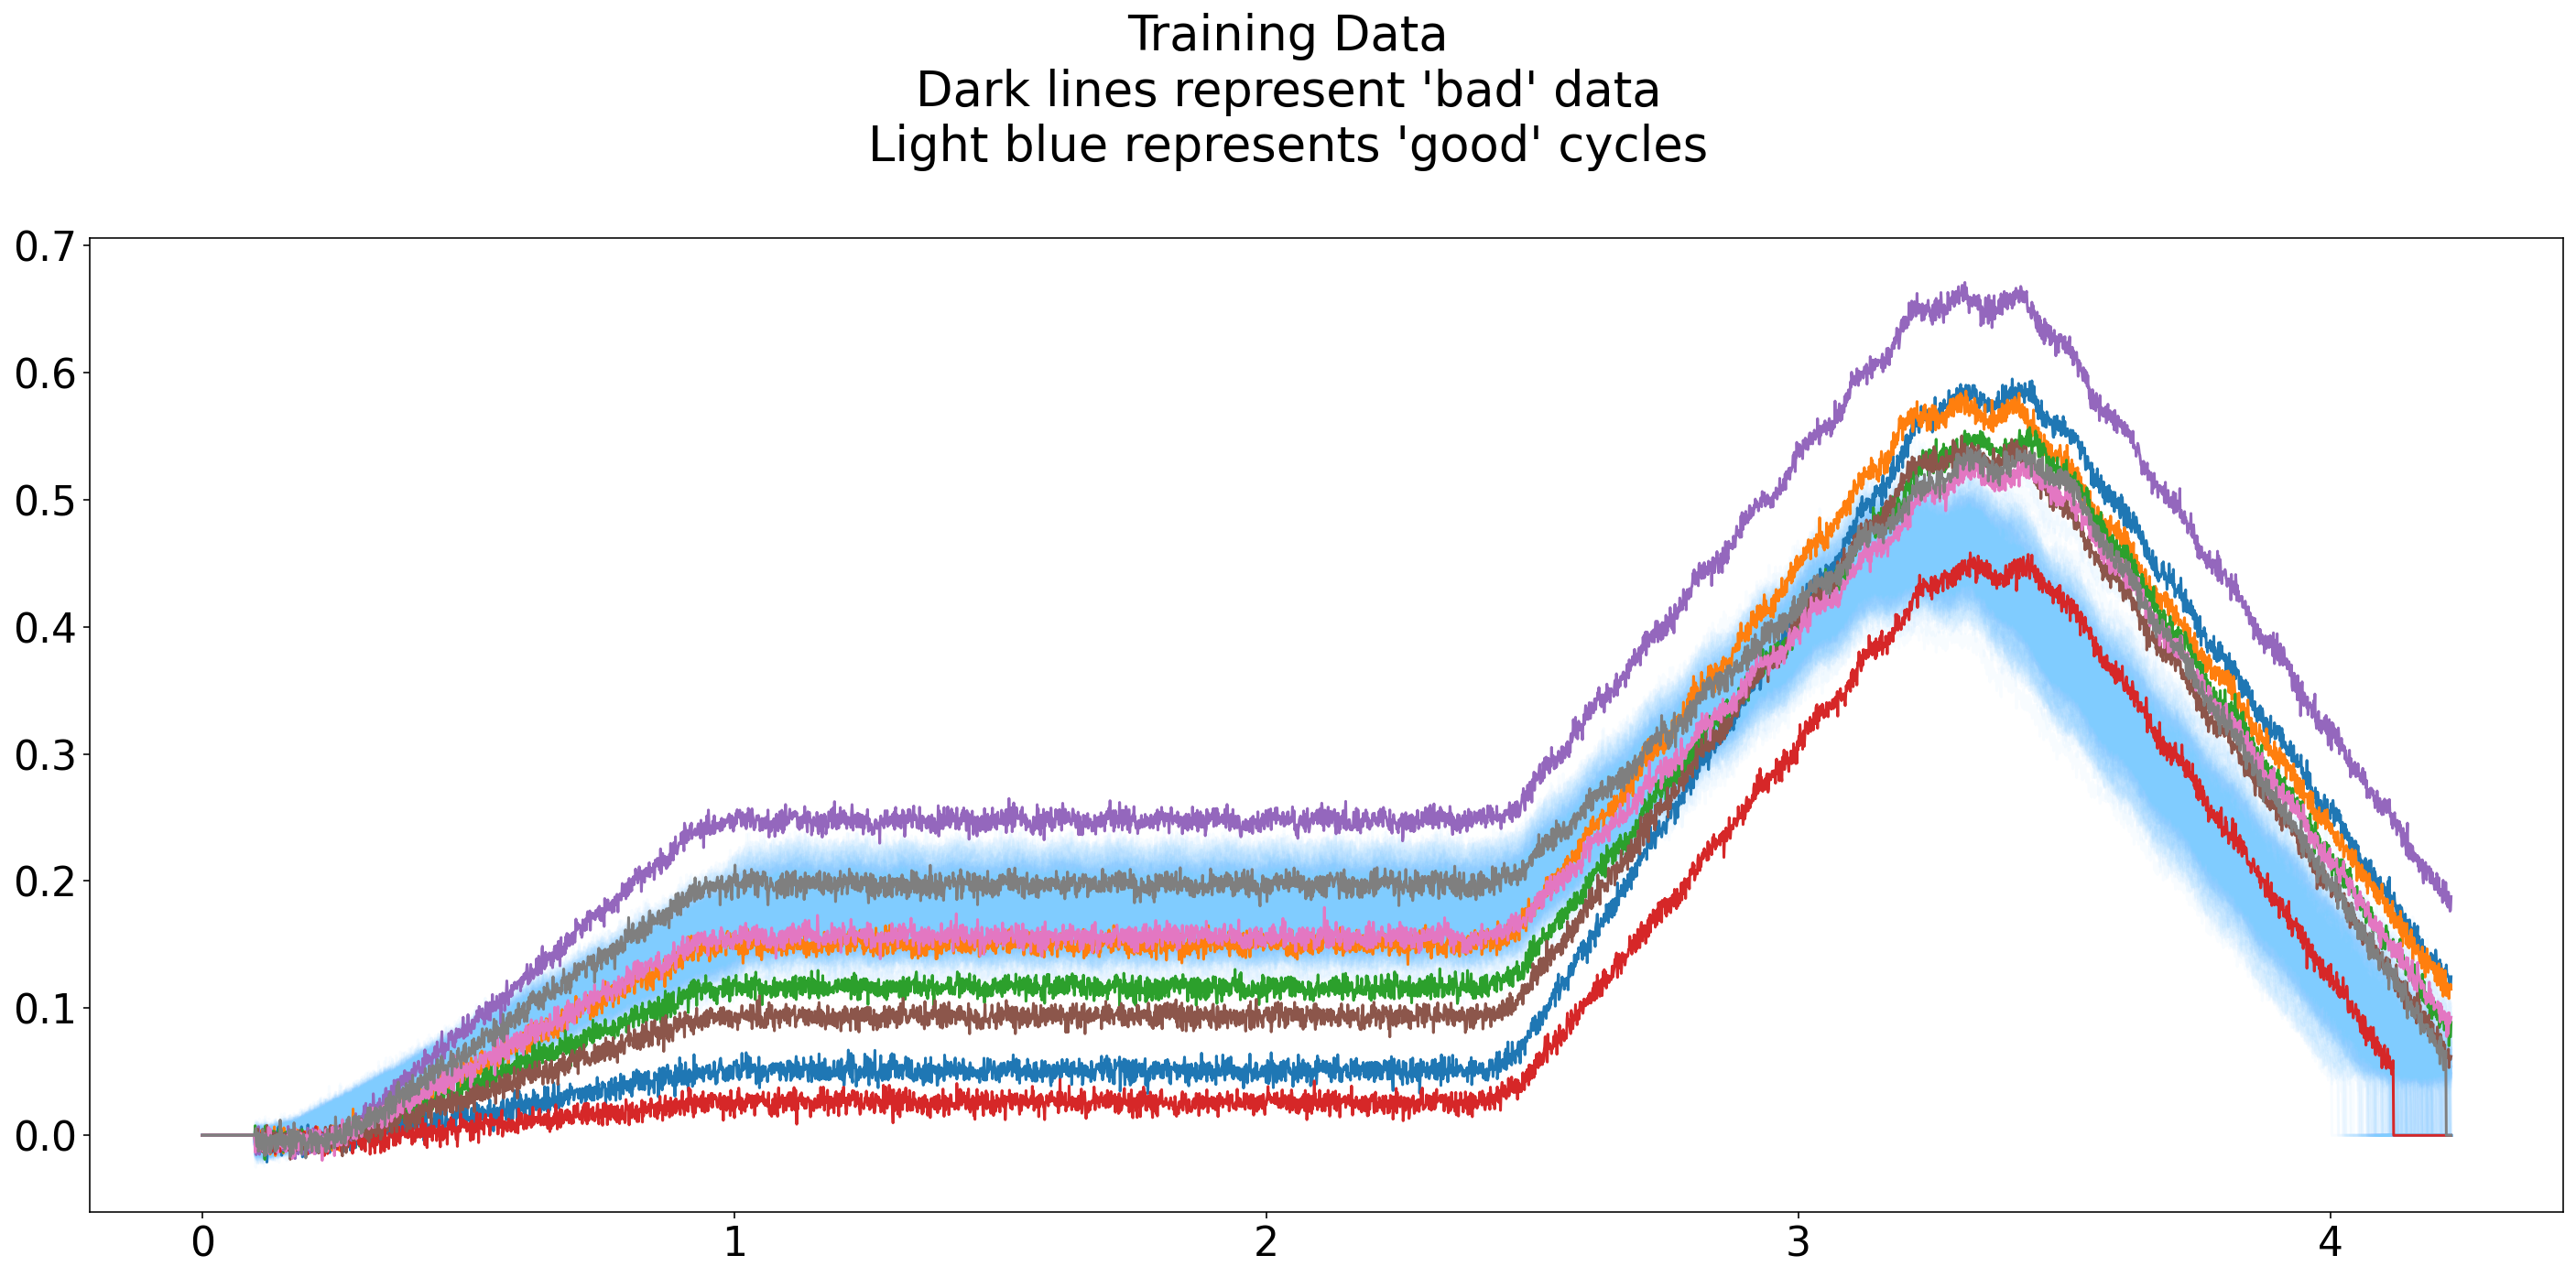

In [7]:
plt.rcParams.update({'font.size': 22})
# Plot the training data
if debug:
    fig, ax = plt.subplots(figsize=(20,10))
    for col in train_df.columns[1:]:
        if 'g' in col:
            ax.plot(train_df['time'], train_df[col], color=(0.5, .8, 1, 0.05)) # plot 'good' data
        else:
            ax.plot(train_df['time'], train_df[col]) # plot 'bad' data
    fig.suptitle('Training Data\nDark lines represent \'bad\' data\nLight blue represents \'good\' cycles')
    fig.tight_layout()

In the plot above, note the head and tail zero values (horizontal lines). Those are the areas where there were missing values in the raw dataset. Also observe how the tail of each signal can end at different points.

> At this point, a good question to ask is can **we** differentiate between the good and bad processes visually?

Plotting the testing data as well might help to answer this.

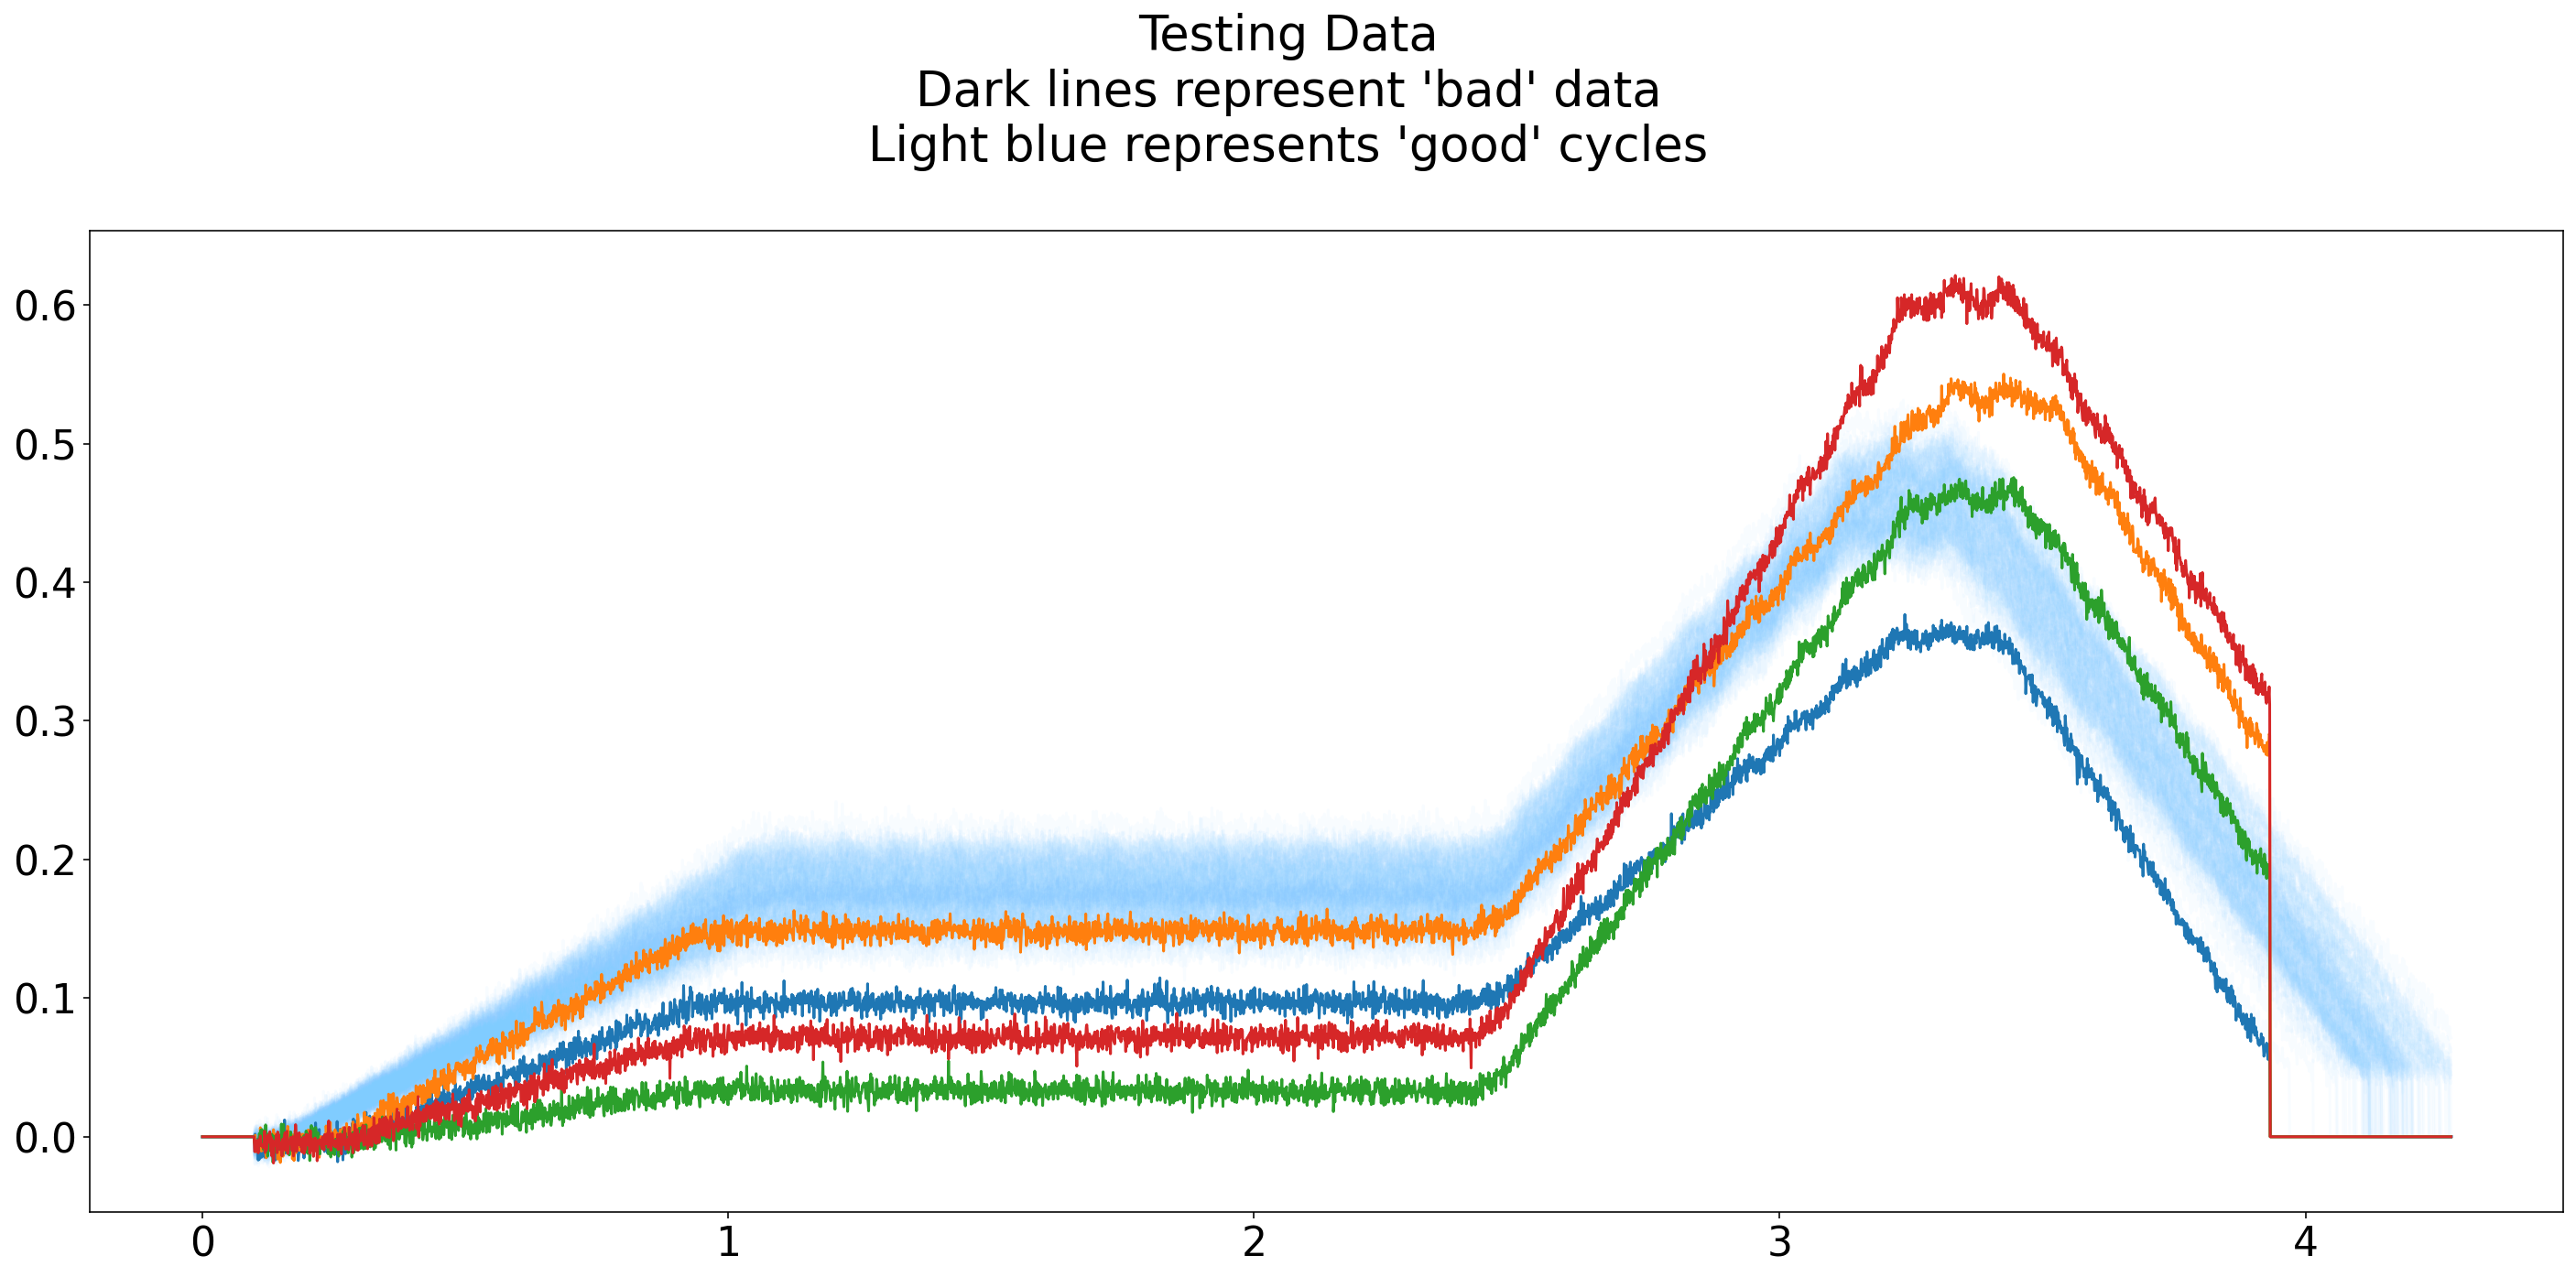

In [8]:
# Plot the testing data
if debug:
    fig, ax = plt.subplots(figsize=(20,10))
    for col in test_df.columns[1:]:
        if 'g' in col:
            ax.plot(test_df['time'], test_df[col], color=(0.5, .8, 1, 0.05)) # plot 'good' data
        else:
            ax.plot(test_df['time'], test_df[col]) # plot 'bad' data
    fig.suptitle('Testing Data\nDark lines represent \'bad\' data\nLight blue represents \'good\' cycles')
    fig.tight_layout()

In [9]:
# Extract the training dataset column names
train_cols = train_df.columns[1:]

In [10]:
# Extract the training features to use for training from the imported dataset
# This is the data we will use to teach the model
X_train = train_df.drop(['time'], axis = 1).transpose()
X_test = test_df.drop(['time'], axis = 1).transpose()

if debug:
    # Original data orientation
    train_df.drop(['time'], axis = 1).head(10)

In [11]:
if debug:
    # Transposed data orientation
    X_train.head(10)

In [12]:
# Adjust for maximum length of individual signals in both train and test datasets
foo = train_df.shape # Store training DataFrame size in foo
bar = test_df.shape # Store testing DataFrame size in bar

if foo[0] >= bar[0]:
    foobar = abs(foo[0] - bar[0])
    # training set is longer, adjust length of test dataset to match training dataset
    df = pd.DataFrame(index=range(foobar), columns=test_df.columns).transpose()
    # Adjust the length of the test dataset, 
    # fill an missing values with zeros, 
    # and transpose the test dataset
    X_test = pd.concat([X_test, df], ignore_index=True, axis = 1).fillna(0)
else:
    foobar = abs(bar[0] - foo[0])
    # testing set is longer, adjust length of training dataset to match test dataset
    df = pd.DataFrame(index=range(foobar), columns=train_df.columns).transpose()
    # Adjust the length of the test dataset, 
    # fill an missing values with zeros, 
    # and transpose the test dataset
    X_train = pd.concat([X_train, df], ignore_index=True, axis = 1).fillna(0)

In [13]:
# Check that length matches (second value below)
if debug:
    print(X_train.shape)
    print(X_test.shape)

(509, 4278)
(104, 4278)


In [14]:
# Create a response variable to use for training from the imported dataset
# The response variable contains the "ground truth" or correct answer for supervised learning
# This will be used to check how well the model performs
train_cols = X_train.index
y_train = []

for el in train_cols:
    if 'g' in el:
        y_train.append(1)
    else:
        y_train.append(0)

y_train = pd.Series(y_train)

In [15]:
# Create the response variable or 'ground truth' for the test dataset
test_cols = X_test.index
y_test = []

for el in test_cols:
    if 'g' in el:
        y_test.append(1)
    else:
        y_test.append(0)

y_test = pd.Series(y_test)

In [16]:
if debug:
    print('*****Training Ground Truth*****')
    print(y_train)
    print('*****Testing Ground Truth*****')
    print(y_test)

*****Training Ground Truth*****
0      1
1      1
2      1
3      1
4      1
      ..
504    0
505    0
506    0
507    0
508    0
Length: 509, dtype: int64
*****Testing Ground Truth*****
0      1
1      1
2      1
3      1
4      1
      ..
99     1
100    0
101    0
102    0
103    0
Length: 104, dtype: int64


> Visually, is there a difference in the portion of two outputs that we can see?

 - [x] Importing data
 - [x] Vizualizing the raw data
 - [ ] Setting up the model
 - [ ] Training the model
 - [ ] Understanding model performance
 - [ ] Tuning the model
 - [ ] Next steps: Training multiple models

# Model Training

We will start our training using a Multilayer Perceptron Classifier. This is a type of Artificial Neural Network (ANN) and are simple to use as they typically only have a single layer. A sample network diagram is below.

<br/>
<div>
<img src="MLP-Framework.png" width="400"/>
</div>
<br/>

The hidden layer is made up of neurons with weighted inputs, an activation function, and an output. Neural Networks can have multiple layers of various numbers and types of neurons. Here we will use a basic type.

<br/>
<div>
<img src="MLP Neuron.png" width="400"/>
</div>
<br/>

<u>Neuron</u>: The basic building block for neural networks

<u>Weights</u>: The weights are very similar to the coefficients used in linear regression. They allow for each input to have a stronger or weaker effect on the neurons activation. The summed weighted inputs go through the activation function.

<u>Activation</u>: The activation function can be thought of as a simple threshold for the neuron to activate. In the simplest case, a neuron will have a threshold of 0.5. If the weighted input were less than the threshold, the neuron output is 0 and if it is above, the neuron output is 1.

In [17]:
# Initialize a Multilayer Perceptron (MLP) Classifier Model
# Enter any desired parameters to be used by the model here
mlp = MLPClassifier(solver='lbfgs', # the solver used,‘lbfgs’ is an optimizer in the family of quasi-Newton methods 
                    activation = 'relu', # activation function for the hidden layer
                    hidden_layer_sizes=(3), # number of and size of hidden layers
                    max_iter=1000) # maximum number of iterations before computation is halted

# Train the model using "fit" on the training data and ground truth data
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=3, max_iter=1000, solver='lbfgs')

In [18]:
# Use the MLP model created earlier to classify the test dataset
# Note that we do not use the 'fit' function on the test dataset
pred_class = pd.Series(mlp.predict(X_test))
if debug:
    print(pred_class)

0      1
1      1
2      1
3      1
4      1
      ..
99     1
100    1
101    0
102    0
103    0
Length: 104, dtype: int64


# Metrics for Evaluating Model Performance

- True Positive = Good product classified as good product
- False Positive = Bad product classified as good product (Type 1 ERROR, miss)

- True Negative = Bad product classified as bad product
- False Negative = Good product classified as bad product (Type 2 ERROR, false alarm)

For more information: https://en.wikipedia.org/wiki/Confusion_matrix

<br/>
<div>
<img src="Confusion Matrix.png" width="400"/>
</div>


Talking points
- No one metric is best for all cases
- Imbalanced Dataset
- Size of dataset (small vs medium vs large vs extra)
- How do we use metrics to select the model and tune the parameters
    - Cost of escaping defect
    - Cost of inspection
    - What might someone do?
- Classification confidence (Confidence interval)

In [19]:
np.seterr(invalid='ignore')

# Build the Confusion Matrix
act_pos = y_test == 1
act_neg = y_test == 0
alignment = y_test == pred_class

true_pos = alignment[act_pos].sum()
true_neg = alignment[act_neg].sum()
false_pos = act_pos[act_pos].shape[0] - true_pos
false_neg = act_neg[act_neg].shape[0] - true_neg

# Accuracy - Proportion of correct classifications
accuracy = (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)

# Precision - number of true positive results divided by the number of all positive results
precision = (true_pos)/(true_pos + false_pos)

# Recall - number of true positive results divided by the number of all samples that should have been identified as positive
recall = (true_pos)/(true_pos + false_neg)

# F-score - combination metric of precision and recall
# Ranges between 0 and 1 (perfect classification)
f_score = 2 * (precision * recall) / (precision+recall)

# Matthew Correlation Coefficient (MCC)
# Measures the quality of binary classifications
# Ranges between -1 and 1 (perfect classification)
mcc = ((true_pos * true_neg) - (false_pos * false_neg)) / sqrt((true_pos + false_pos) * (true_pos + false_neg) * (true_neg + false_pos) * (true_neg + false_neg))

In [20]:
# Display the calculated metrics
print(f'TP: {true_pos}')
print(f'TN: {true_neg}')
print(f'FP: {false_pos}')
print(f'FN: {false_neg}')
print(f'accuracy: {accuracy:.3f}')
print(f'precision: {precision:.3f}')
print(f'recall: {recall:.3f}')
print(f'f_score: {f_score:.3f}')
print(f'mcc: {mcc:.3f}')

TP: 99
TN: 3
FP: 1
FN: 1
accuracy: 0.981
precision: 0.990
recall: 0.990
f_score: 0.990
mcc: 0.740


In [21]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10, 10), max_iter=500)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=500, solver='lbfgs')

In [22]:
pred_class = pd.Series(mlp.predict(X_test))
if debug:
    print(pred_class)

0      1
1      1
2      1
3      1
4      1
      ..
99     1
100    1
101    0
102    0
103    0
Length: 104, dtype: int64


In [23]:
test_cols = test_df.columns[1:]
y_test = []

for el in test_cols:
    if 'g' in el:
        y_test.append(1)
    else:
        y_test.append(0)

y_test = pd.Series(y_test)

print(f'TP: {true_pos}')
print('TN: ', true_neg)
print('FP: ', false_pos)
print('FN: ', false_neg)
print(f'accuracy: {accuracy:.3f}')
print(f'precision: {precision:.3f}')
print(f'recall: {recall:.3f}')
print(f'f_score: {f_score:.3f}')
print(f'mcc: {mcc:.3f}')

TP: 99
TN:  3
FP:  1
FN:  1
accuracy: 0.981
precision: 0.990
recall: 0.990
f_score: 0.990
mcc: 0.740


 - [x] Importing data
 - [x] Vizualizing the raw data
 - [x] Setting up the model
 - [x] Training the model
 - [x] Understanding model performance
 - [x] Tuning the model
 - [ ] Next steps: Training multiple models

# Multi-model setup

In [24]:
# import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# import model types
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def confusion_matrix_scorer(clf, X, y):
     y_pred = clf.predict(X)
     cm = confusion_matrix(y, y_pred)
     return {'tn': cm[0, 0], 'fp': cm[0, 1],
             'fn': cm[1, 0], 'tp': cm[1, 1]}

# Set up k-fold validation
k=2
cv = KFold(n_splits=k, random_state=7, shuffle=True)

# zero out results arrays
ACC = []
MCC = []
FoldACC = []
FoldBalACC = []
FoldMCC = []

FoldACC_error = []
FoldBalACC_error = []
FoldMCC_error = []
cv_results = []
mod = []

# initialize Matthews Correlation Coef scorer
mcc_scorer = make_scorer(matthews_corrcoef)

# name of each desired model
# NOTE: These must match the order of "classifiers" variable
names = [
    "Nearest Neighbors", 
    "Linear SVM", 
    "RBF SVM", 
    "Gaussian Process",
    "Decision Tree", 
    "Random Forest", 
    "Multi-Layer Perceptron", 
    "AdaBoost",
    "Naive Bayes"
    ]

# model and desired parameters
classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(kernel='rbf', gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10, 10), max_iter=500),
    AdaBoostClassifier(),
    GaussianNB()
    ]

In [25]:
# iterate over classifiers

print('Training Models using Training Data')

for name, clf in zip(names, classifiers):
    print('\n')
    print(name)
    mod.append(clf.fit(X_train, y_train))
    
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    print('%s-Fold Acc: %.2f%% (Std Dev %.2f)' % (k, np.mean(scores)*100, np.std(scores)))
    FoldACC.append(np.mean(scores))
    FoldACC_error.append(np.std(scores))
    
    scores = cross_val_score(clf, X_train, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    print('%s-Fold Bal Acc: %.2f%% (Std Dev %.2f)' % (k, np.mean(scores)*100, np.std(scores)))
    FoldBalACC.append(np.mean(scores))
    FoldBalACC_error.append(np.std(scores))
    
    scores = cross_val_score(clf, X_train, y_train, scoring=mcc_scorer, cv=cv, n_jobs=-1)
    print('%s-Fold Mcc: %.3f (Std Dev %.2f)' % (k, np.mean(scores), np.std(scores)))
    FoldMCC.append(np.mean(scores))
    FoldMCC_error.append(np.std(scores))
    
    cv_results.append([name, cross_validate(clf, X_train, y_train, cv=k, scoring=confusion_matrix_scorer)])

Training Models using Training Data


Nearest Neighbors
2-Fold Acc: 99.21% (Std Dev 0.00)
2-Fold Bal Acc: 77.50% (Std Dev 0.03)
2-Fold Mcc: 0.738 (Std Dev 0.03)


Linear SVM
2-Fold Acc: 98.63% (Std Dev 0.01)
2-Fold Bal Acc: 62.50% (Std Dev 0.12)
2-Fold Mcc: 0.352 (Std Dev 0.35)


RBF SVM
2-Fold Acc: 98.23% (Std Dev 0.00)
2-Fold Bal Acc: 50.00% (Std Dev 0.00)
2-Fold Mcc: 0.000 (Std Dev 0.00)


Gaussian Process
2-Fold Acc: 98.23% (Std Dev 0.00)
2-Fold Bal Acc: 50.00% (Std Dev 0.00)
2-Fold Mcc: 0.000 (Std Dev 0.00)


Decision Tree
2-Fold Acc: 98.62% (Std Dev 0.00)
2-Fold Bal Acc: 82.30% (Std Dev 0.08)
2-Fold Mcc: 0.632 (Std Dev 0.14)


Random Forest
2-Fold Acc: 98.82% (Std Dev 0.00)
2-Fold Bal Acc: 67.50% (Std Dev 0.08)
2-Fold Mcc: 0.654 (Std Dev 0.21)


Multi-Layer Perceptron
2-Fold Acc: 98.43% (Std Dev 0.00)
2-Fold Bal Acc: 70.00% (Std Dev 0.20)
2-Fold Mcc: 0.779 (Std Dev 0.11)


AdaBoost
2-Fold Acc: 99.61% (Std Dev 0.00)
2-Fold Bal Acc: 83.75% (Std Dev 0.04)
2-Fold Mcc: 0.732 (Std Dev 



*****Saving result plots*****




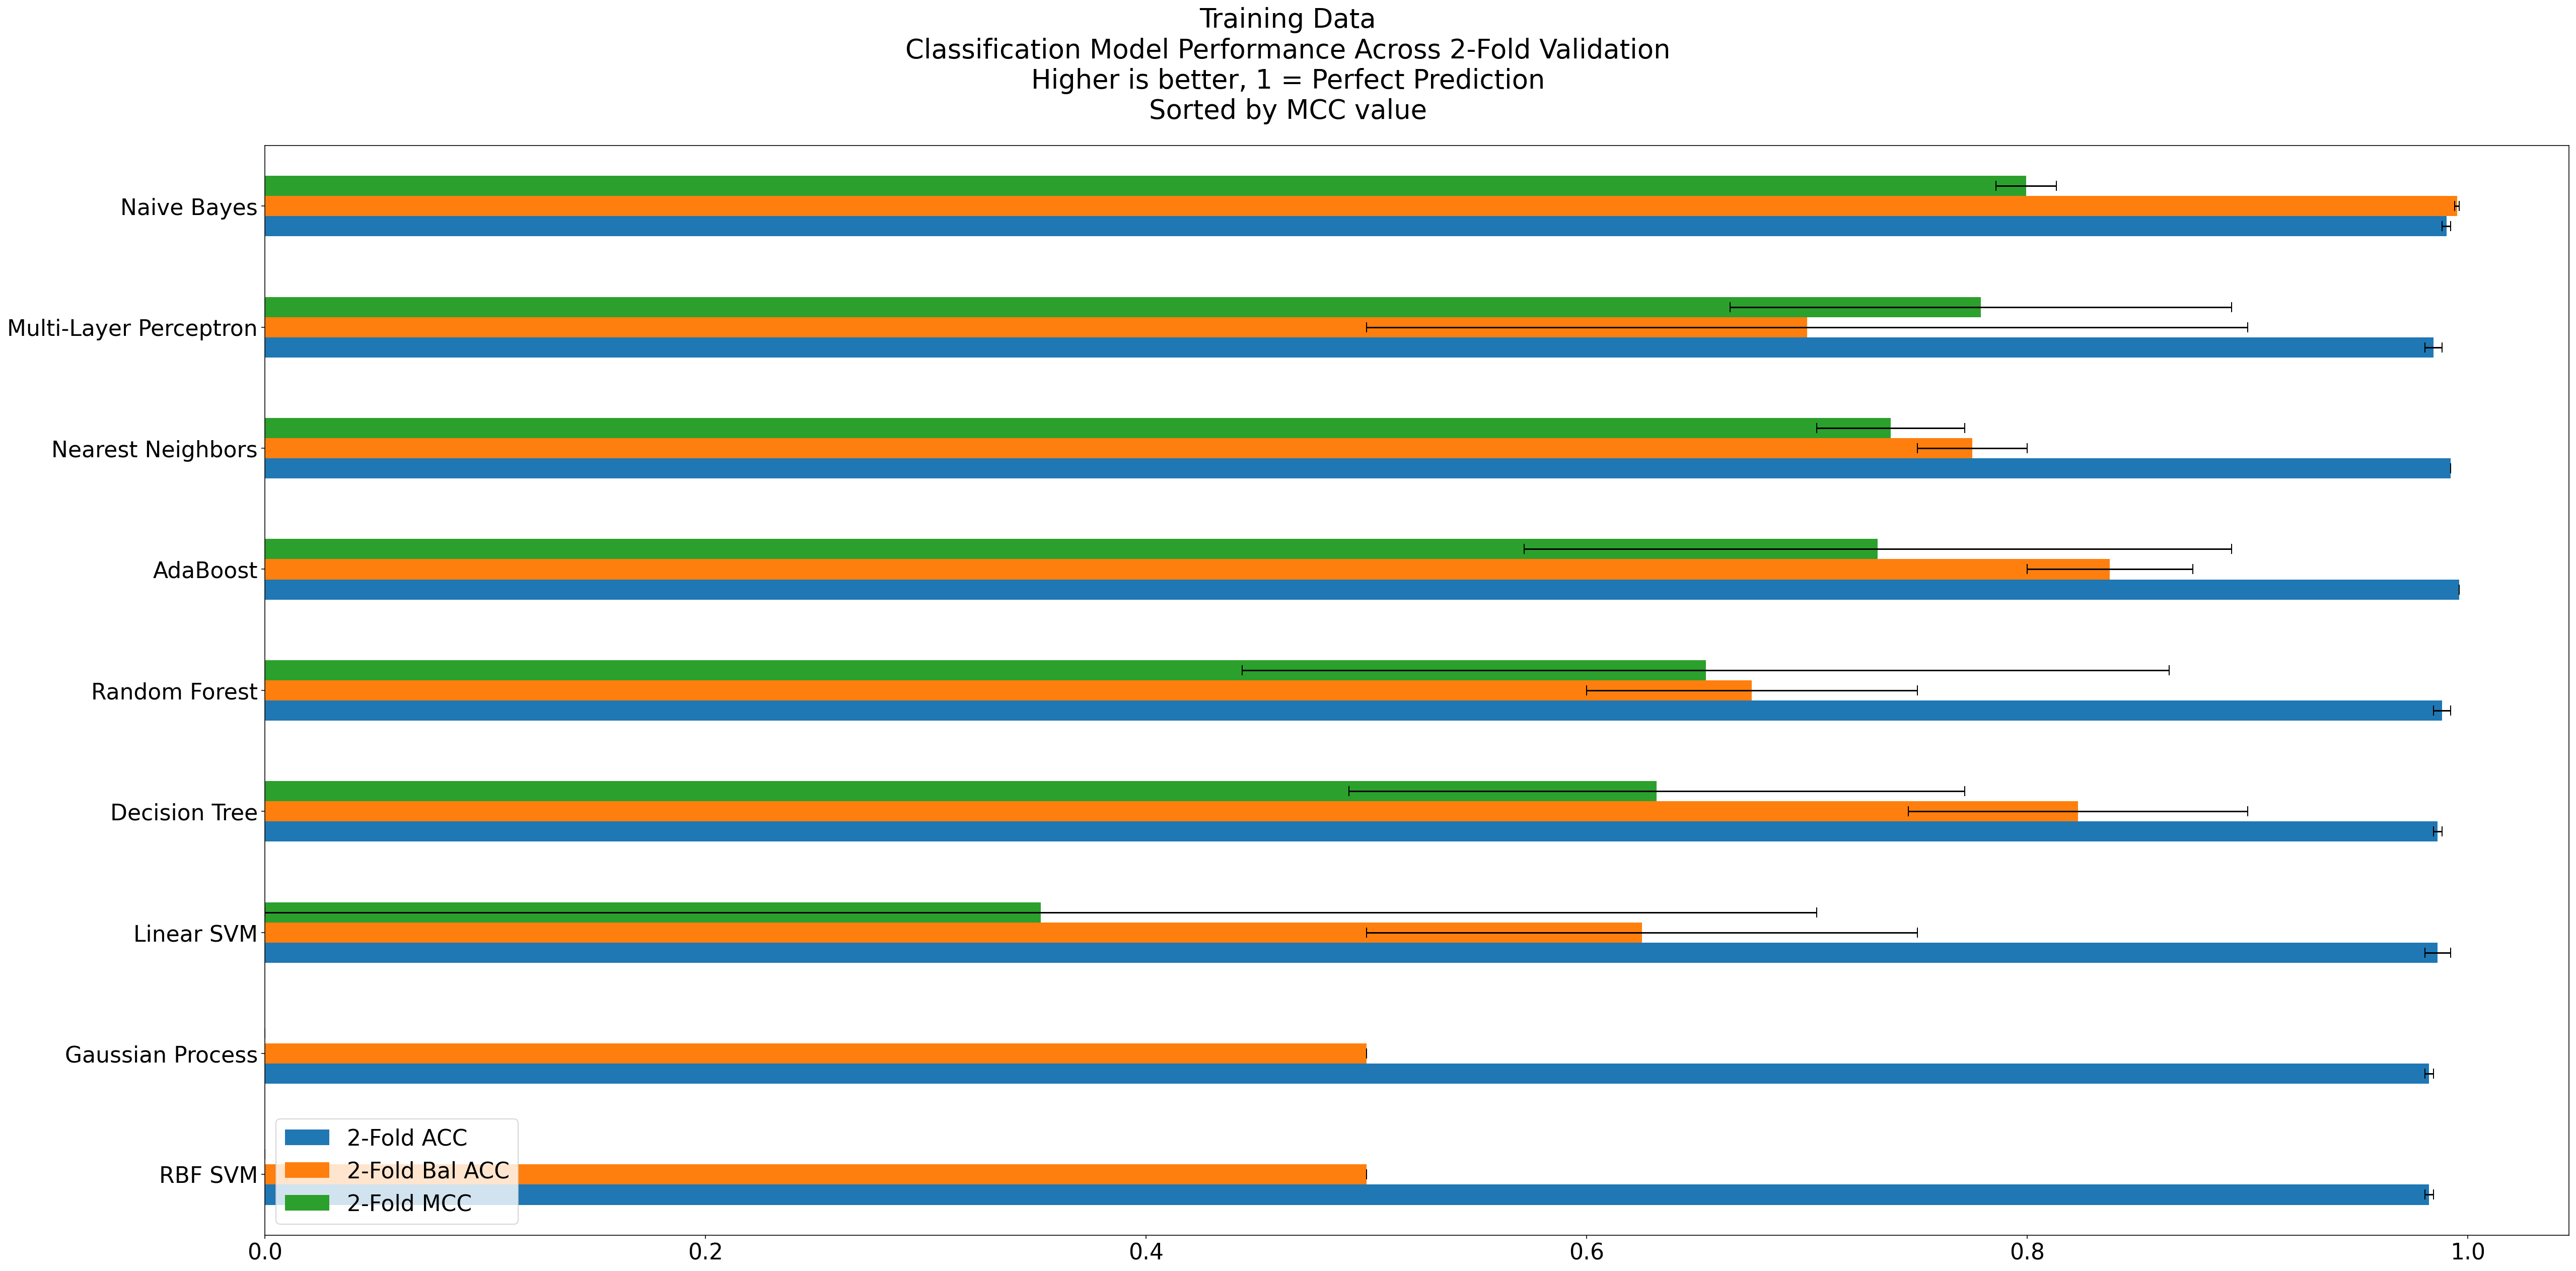

In [26]:
plt.rcParams.update({'font.size': 22})
saveLocation = ''

Results = pd.DataFrame({'%s-Fold ACC'%k:FoldACC,
                        '%s-Fold Bal ACC'%k:FoldBalACC,
                        '%s-Fold MCC'%k:FoldMCC
                        }, index=names)


Errors = pd.DataFrame({'%s-Fold ACC'%k:FoldACC_error,
                        '%s-Fold Bal ACC'%k:FoldBalACC_error,
                        '%s-Fold MCC'%k:FoldMCC_error
                        }, index=names)

print('\n\n*****Saving result plots*****\n\n')

ax = Results[[ col for col in Results if 'Fold' in col]].sort_values(by='%s-Fold MCC'%k,ascending=True).plot.barh(figsize=(36,18), xerr=Errors, capsize=5)
plt.suptitle("Training Data\nClassification Model Performance Across %d-Fold Validation\nHigher is better, 1 = Perfect Prediction\nSorted by MCC value"%(k))
plt.tight_layout()
plt.savefig(saveLocation + 'ModelPerformance_AllkFoldedFeatures.png', dpi=150)

 - [x] Importing data
 - [x] Vizualizing the raw data
 - [x] Setting up the model
 - [x] Training the model
 - [x] Understanding model performance
 - [x] Tuning the model
 - [x] Next steps: Training multiple models

## Where to go from here:
#### Free online courses
- Stanford 'Machine Learning' https://coursera.org/share/f1160ba8e2f72c73b50cafff891ea67e
- Johns Hopkins 'Regression Models' https://coursera.org/share/0a254d4b90a25ebf1969d7b29c94c274
- Johns Hopkins 'Practical Machine Learning' https://coursera.org/share/8bba9b9597ce875d6b9976899270366b

#### Online Resources
- Towards Data Science - tutorials and code examples https://towardsdatascience.com/
- Stack Overflow - Q&A forum for help when you get stuck https://stackoverflow.com/
- Google or your search engine of choice is your best helper

#### Reach out to Andy Henderson (andy.hendeson@praemo.com) or Matthew Krugh (mkrugh@clemson.edu) to connect